### Demonstration of Full Pipeline Capabilities
Index:
1) Single-cell no-hsds calls, LOM computation of wind speed and direction
2) Generation of wind rose for speed and wind direction
3) Wind rose projected onto map of buildings
4) Generation of power rose for kW generated each hour and wind direction
5) Power rose projected onto map of buildings
6) Wind rose projected onto map of buildings with potential turbine locations and their respective power outputs


In [20]:
import numpy as np
import pandas as pd
import time
import h5pyd
import geopandas as gpd
from dw_tap.data_fetching import getData
from dw_tap.power_output import estimate_power_output
from dw_tap.lom import run_lom

z_turbine = 40 # turbine height in [m]
lat, lon = 39.32856, -89.40238
obstacle_file = "../sites/180-Manual1.geojson"

t_start = time.time()

#Read in data from CSV file instead of hsds + getData
atmospheric_df = pd.read_csv("../data/180_1year_12hourgranularity.csv")
# Temporary (later need to resave csv without index column) 
if "Unnamed: 0" in atmospheric_df.columns:
    atmospheric_df.drop(columns=["Unnamed: 0"], inplace=True)

obstacles_df = gpd.read_file(obstacle_file)
# Leave in only relevant columns
obstacles_df = obstacles_df[["height", "geometry"]]

x1_turbine, y1_turbine = lat, lon
xy_turbine = [np.array([x1_turbine, y1_turbine])]

t_lom_start = time.time()
predictions_df = \
    run_lom(atmospheric_df, obstacles_df, xy_turbine, z_turbine).join(atmospheric_df["wd"])
t_lom = time.time() - t_lom_start
print('Running LOM: %.2f (s)' % t_lom)

t_power_start = time.time()
kw, above_curve, below_curve, above_curve_list, below_curve_list = \
    estimate_power_output(predictions_df, atmospheric_df["temp"], atmospheric_df["pres"])
t_power = time.time() - t_power_start
print('Power estimation: %.2f (s)' % t_power)

t_total = time.time()-t_start
print('Total time: %.2f (s)' % t_total)

LOM time : 0.1  min
Running LOM: 5.96 (s)
Power estimation: 0.02 (s)
Total time: 6.05 (s)


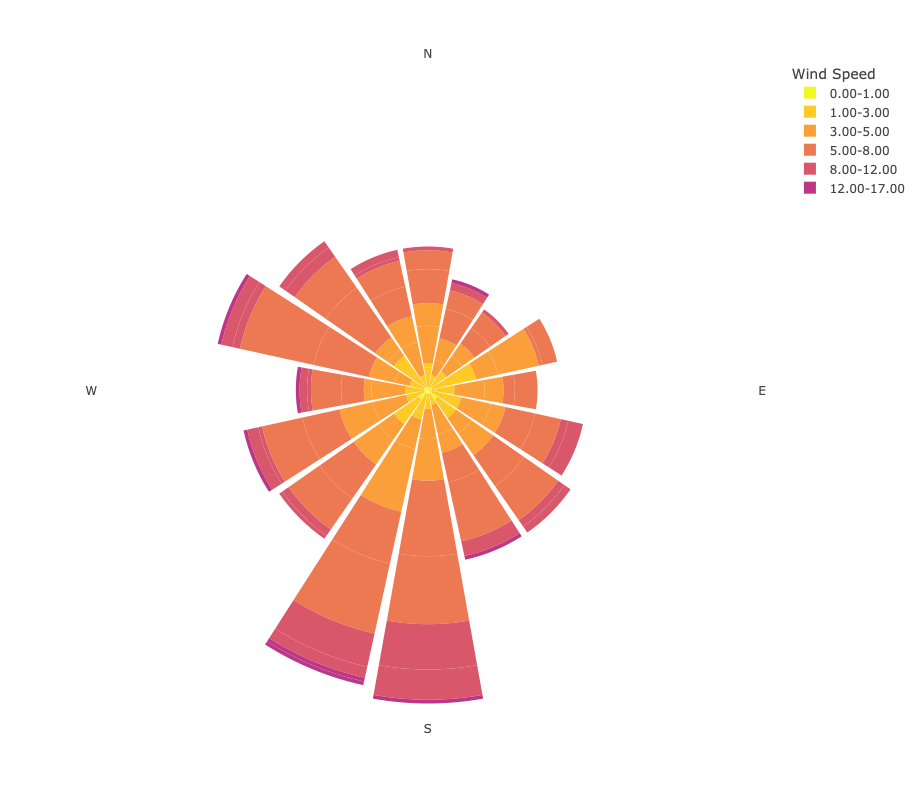

In [21]:
#Windorse for windspeed and direction
import plotly.express as px
import pandas as pd
from rosely import WindRose
WR = WindRose(predictions_df)
names = {'nonlinear':'ws'}
WR.calc_stats(normed=False, bins=[0, 1, 3, 5, 8, 12, 17])

fig = px.bar_polar(WR.wind_df, r="frequency", theta="direction",
                    color="speed", template="xgridoff", color_discrete_sequence= px.colors.sequential.Plasma_r,
                    width=800, height=800)

fig.update_layout(
    polar = dict(
        radialaxis = dict(showticklabels=False, ticks='', showline=False), 
        angularaxis = dict(ticks='', tickmode="array", tickvals=['N', 'NNE', 'NE', 
                                                      'ENE', 'E', 'ESE', 'SE',
                                                      'SSE', 'S', 'SSW', 'SW', 
                                                      'WSW', 'W', 'WNW', 'NW',
                                                      'NNW'], ticktext=['N', '', '', 
                                                      '', 'E', '', '',
                                                      '', 'S', '', '', 
                                                      '', 'W', '', '',
                                                      ''], showline=False),
        bgcolor = "rgba(0,0,0,0)"
    )
)
fig.update_layout({
    'plot_bgcolor': 'rgba(0,0,0,0)',
    'paper_bgcolor': 'rgba(0,0,0,0)', 
    'polar_radialaxis_gridcolor' : 'rgba(0,0,0,0)',
    'polar_angularaxis_gridcolor' : 'rgba(0,0,0,0)',
    'legend' : dict(title="Wind Speed")
})

fig.show()
fig.write_image("windrose.png")


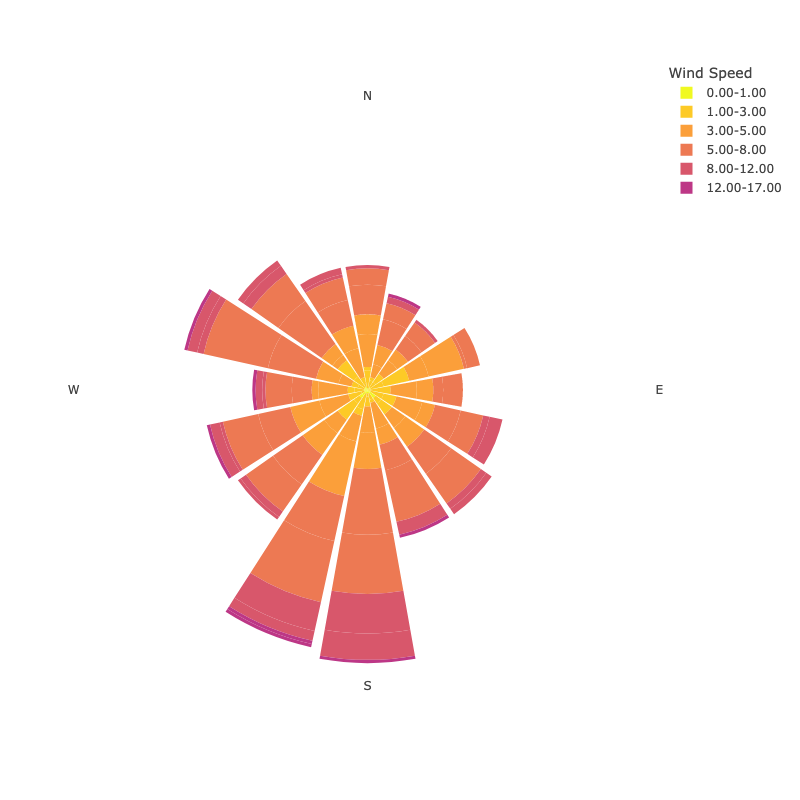

In [22]:
import math
import pandas as pd
import pydeck as pdk

# Load in the JSON data
DATA_URL = "../sites/map-180.geojson"
json = pd.read_json(DATA_URL)
df = pd.DataFrame()

# Custom color scale
COLOR_RANGE = [
    [65, 182, 196],
    [127, 205, 187],
    [199, 233, 180],
    [237, 248, 177],
    [255, 255, 204],
    [255, 237, 160],
    [254, 217, 118],
    [254, 178, 76],
    [253, 141, 60],
    [252, 78, 42],
    [227, 26, 28],
    [189, 0, 38],
    [128, 0, 38],
]

BREAKS = [5,10,15,20,25,30,35,40,45]


def color_scale(val):
    for i, b in enumerate(BREAKS):
        if val < b:
            return COLOR_RANGE[i]
    return COLOR_RANGE[i]


def calculate_elevation(val):
    return math.sqrt(val) * 10

# Parse the geometry out in Pandas
df["coordinates"] = json["features"].apply(lambda row: row["geometry"]["coordinates"])
df["height"] = json["features"].apply(lambda row: row["properties"]["height"])
df["elevation"] = json["features"].apply(lambda row: calculate_elevation(row["properties"]["height"]))
df["fill_color"] = json["features"].apply(lambda row: color_scale(row["properties"]["height"]))


# Add sunlight shadow to the polygons
sunlight = {
    "@@type": "_SunLight",
    "timestamp": 1564696800000,  # Date.UTC(2019, 7, 1, 22),
    "color": [255, 255, 255],
    "intensity": 1.0,
    "_shadow": True,
}

ambient_light = {"@@type": "AmbientLight", "color": [255, 255, 255], "intensity": 1.0}

lighting_effect = {
    "@@type": "LightingEffect",
    "shadowColor": [0, 0, 0, 0.5],
    "ambientLight": ambient_light,
    "directionalLights": [sunlight],
}

view_state = pdk.ViewState(
    **{"latitude": 39.3282808777312, "longitude": -89.40247893333435, "zoom": 15, "maxZoom": 20, "pitch": 0, "bearing": 0}
)

LAND_COVER = [[[0, 40], [0, 40.5], [-.5, 40.5], [-.5, 40]]]

polygon_layer_base = pdk.Layer(
    "PolygonLayer",
    df,
    id="geojson",
    opacity=0.4,
    stroked=False,
    get_polygon="coordinates",
    filled=False,
    extruded=True,
    wireframe=True,
    get_elevation="elevation",
    get_fill_color="fill_color",
    get_line_color=[255, 255, 255],
    auto_highlight=True,
    pickable=True,
)

polygon_layer_3d = pdk.Layer(
    "PolygonLayer",
    df,
    id="geojson",
    opacity=0.2,
    stroked=False,
    get_polygon="coordinates",
    filled=True,
    wireframe=True,
    get_elevation="elevation",
    get_fill_color="fill_color",
    get_line_color=[255, 255, 255],
    auto_highlight=True,
    pickable=True,
)

BOUNDS = [
    [-89.4047, 39.32655],
    [-89.4047, 39.33055],
    [-89.3997, 39.33055],
    [-89.3997, 39.32655],
]

bitmap_layer = pdk.Layer(
    "BitmapLayer", 
    image='windrose.png', 
    bounds=BOUNDS, 
    opacity=1, 
    pitch=0
)
#Original
tooltip = {"html": "<b>Height:</b> {height}"}

r = pdk.Deck(
    [bitmap_layer, polygon_layer_3d, polygon_layer_base],
    initial_view_state=view_state,
    effects=[lighting_effect],
    map_style=pdk.map_styles.ROAD,
    tooltip=tooltip,
)
r.to_html("polygon_layer.html")

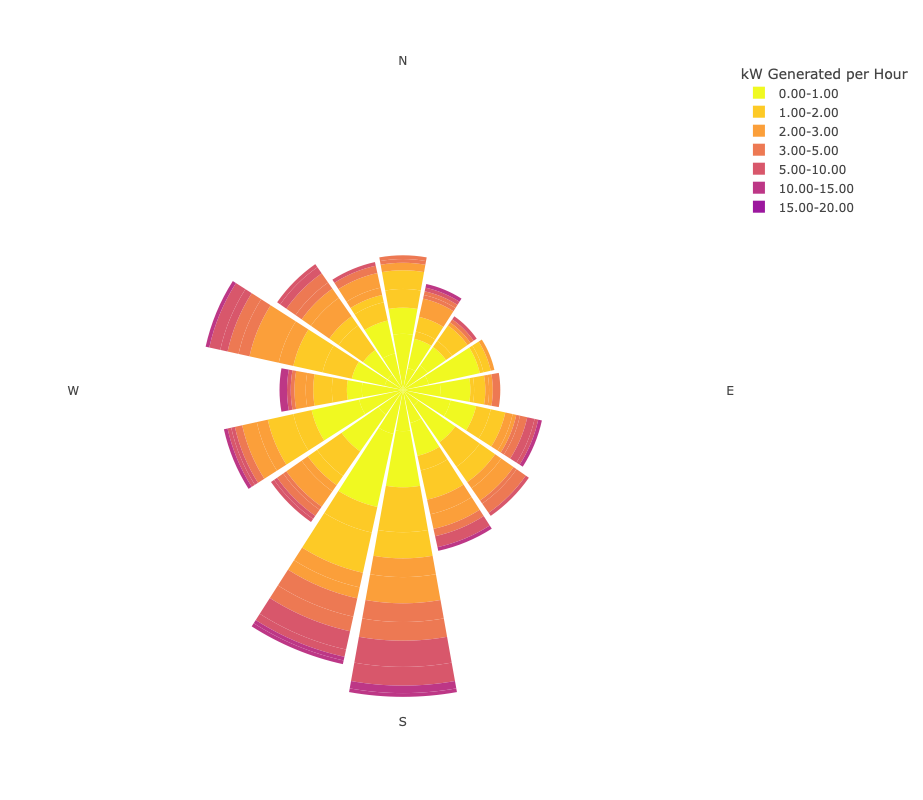

In [51]:
#Windrose for power generation based on direction
power_df = pd.DataFrame(columns = ["power_output", "wd"])
power_df["power_output"] = kw
power_df["wd"] = atmospheric_df["wd"]

WR = WindRose(power_df)
names = {'power_output':'ws'}
WR.calc_stats(normed=False, variable_names=names, bins=[0, 1, 2, 3, 5, 10, 15, 20])

fig = px.bar_polar(WR.wind_df, r="frequency", theta="direction",
                    color="speed", template="xgridoff", color_discrete_sequence= px.colors.sequential.Plasma_r,
                    width=800, height=800)

fig.update_layout(
    polar = dict(
        radialaxis = dict(showticklabels=False, ticks='', showline=False), 
        angularaxis = dict(ticks='', tickmode="array", tickvals=['N', 'NNE', 'NE', 
                                                      'ENE', 'E', 'ESE', 'SE',
                                                      'SSE', 'S', 'SSW', 'SW', 
                                                      'WSW', 'W', 'WNW', 'NW',
                                                      'NNW'], ticktext=['N', '', '', 
                                                      '', 'E', '', '',
                                                      '', 'S', '', '', 
                                                      '', 'W', '', '',
                                                      ''], showline=False),
        bgcolor = "rgba(0,0,0,0)"
    )
)
fig.update_layout({
    'plot_bgcolor': 'rgba(0,0,0,0)',
    'paper_bgcolor': 'rgba(0,0,0,0)', 
    'polar_radialaxis_gridcolor' : 'rgba(0,0,0,0)',
    'polar_angularaxis_gridcolor' : 'rgba(0,0,0,0)',
    'legend' : dict(title="kW Generated per Hour"),
    #'showlegend' : False
})
#fig.update(fig, showlegend = "false")

fig.show()
fig.write_image("power_generated.png")


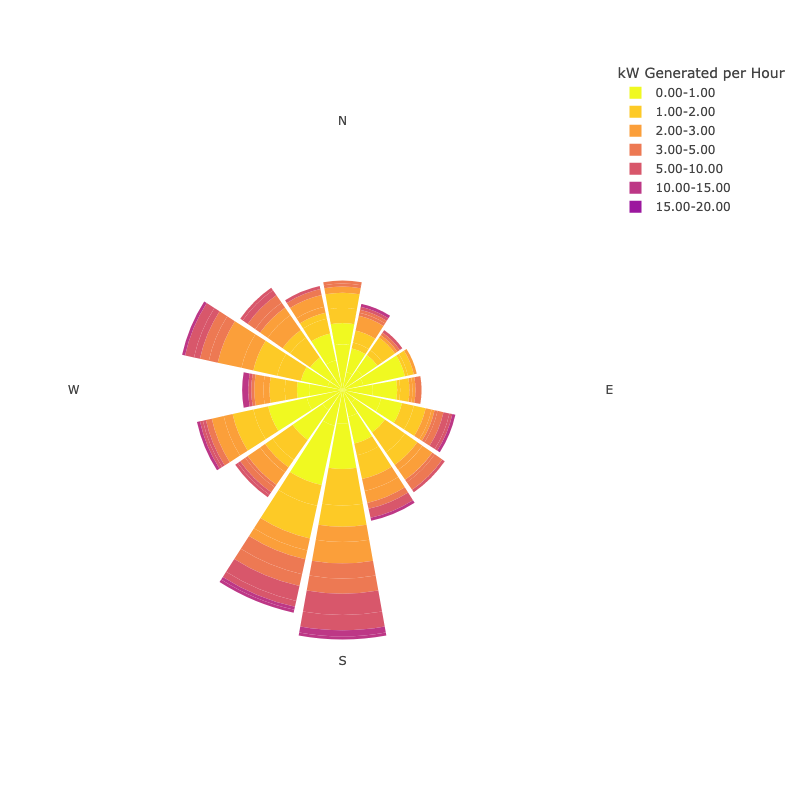

In [52]:
bitmap_layer1 = pdk.Layer(
    "BitmapLayer", 
    image='power_generated.png', 
    bounds=BOUNDS, 
    opacity=1, 
    pitch=0
)
r2 = pdk.Deck(
    [bitmap_layer1, polygon_layer_3d, polygon_layer_base],
    initial_view_state=view_state,
    effects=[lighting_effect],
    map_style=pdk.map_styles.ROAD,
    tooltip=tooltip,
)

r2.to_html("polygon_layer2.html")

In [54]:
tooltip = {'html': '<img src="windrose.png" style="width:500px;height:500px"/> ', 
           'style': {'background-color' : 'transparent',
                    'z-index':-1, 'left':'-250px', 'top' : '-250px'}}
DATA_URL2 = "grid_point.json"
json = pd.read_json(DATA_URL2)
grid_df = pd.DataFrame()
grid_df["latitude"] = json["features"].apply(lambda row: row["geometry"]["coordinates"][1])
grid_df["longitude"] = json["features"].apply(lambda row: row["geometry"]["coordinates"][0])

grid_layer = pdk.Layer(
    'ScatterplotLayer',
    data=grid_df,
    get_position=['longitude', 'latitude'],
    get_radius=5,  
    pickable=True,
    filled=True,
)
polygon_layer_base_2 = pdk.Layer(
    "PolygonLayer",
    df,
    id="geojson",
    opacity=0.4,
    stroked=False,
    get_polygon="coordinates",
    filled=False,
    extruded=True,
    wireframe=True,
    get_elevation="elevation",
    get_fill_color="fill_color",
    get_line_color=[255, 255, 255],
    auto_highlight=True,
    pickable=False,
)

polygon_layer_3d_2 = pdk.Layer(
    "PolygonLayer",
    df,
    id="geojson",
    opacity=0.2,
    stroked=False,
    get_polygon="coordinates",
    filled=True,
    wireframe=True,
    get_elevation="elevation",
    get_fill_color="fill_color",
    get_line_color=[255, 255, 255],
    auto_highlight=True,
    pickable=False,
)
r = pdk.Deck(
    [grid_layer, polygon_layer_3d_2, polygon_layer_base_2],
    initial_view_state=view_state,
    effects=[lighting_effect],
    map_style=pdk.map_styles.ROAD,
    tooltip=tooltip,
)
r.to_html("polygon_layer.html")